# Setup

## Import and check packages

In [1]:
import sys
import pandas as pd
import numpy as np
import nltk
import gensim
import sklearn
import re, string
from nltk.stem import PorterStemmer
import multiprocessing
import os
import csv
import matplotlib
import scipy

In [2]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, \
                                            CountVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [3]:
print('Version check:')
print('Python: {}'.format(sys.version))
print('pandas: {}'.format(pd.__version__))
print('nltk: {}'.format(nltk.__version__))
print('gensim: {}'.format(gensim.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('regex: {}'.format(re.__version__))
print('scipy: {}'.format(scipy.__version__))

Version check:
Python: 3.8.2 (default, Apr 27 2020, 15:53:34) 
[GCC 9.3.0]
pandas: 1.0.3
nltk: 3.5
gensim: 3.8.3
sklearn: 0.22.2.post1
regex: 2.2.1
scipy: 1.4.1


## Import data

In [4]:
# train_df = pd.read_pickle('data_files/train_df.pkl')
# train_df.head()

In [5]:
# test_df = pd.read_pickle('data_files/test_df.pkl')
# test_df.head()

In [6]:
df = pd.read_pickle('data_files/processed_data.pkl')
shuffled_df = df.sample(frac=1)
shuffled_df.head()

,,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,review_word_count
1943,1536,on 11/19/06 09:07 AM (PST),Deanna Curley,2005 Cadillac Escalade SUV AWD 4dr SUV (6.0L 8...,2 D Boat,We have had Cadillacs before. We also had an...,4.375,246
3574,2910,on 10/05/13 13:23 PM (PDT),jbeck204,2012 Hyundai Veloster Hatchback 3dr Hatchback ...,Wouldn't choose anything different <3,I bought this car used in April of 2013. I ab...,4.625,543
3037,2960,on 01/31/08 19:59 PM (PST),JP,2004 Jeep Liberty SUV Limited 4WD 4dr SUV (3.7...,Mountain Jeep,My Jeep has been great. Very reliable and can...,4.625,329
5246,4879,on 02/05/17 19:33 PM (PST),Charles Rockwell,2009 Jeep Commander SUV Overland 4dr SUV 4WD (...,Quite Expensive to Maintain Despite Warranty,We bought this car because for an extra $2500...,3,2263
8574,6152,on 09/08/17 09:30 AM (PDT),Scott,2015 Chevrolet Silverado 1500 Crew Cab LT 4dr ...,5.3L V8 4WD Crew Cab is wonderful!,I was actually looking to buy a Suburban but ...,5,367


In [7]:
shuffled_df.dtypes

                     object
Review_Date          object
Author_Name          object
Vehicle_Title        object
Review_Title         object
Review               object
Rating               object
review_word_count     int64
dtype: object

In [8]:
shuffled_df.Rating = shuffled_df.Rating.astype('float')

In [9]:
shuffled_df.dtypes

                      object
Review_Date           object
Author_Name           object
Vehicle_Title         object
Review_Title          object
Review                object
Rating               float64
review_word_count      int64
dtype: object

In [10]:
shuffled_df['rounded_rating'] = shuffled_df.Rating.round(0)

In [11]:
shuffled_df.head()

,,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,review_word_count,rounded_rating
1943,1536,on 11/19/06 09:07 AM (PST),Deanna Curley,2005 Cadillac Escalade SUV AWD 4dr SUV (6.0L 8...,2 D Boat,We have had Cadillacs before. We also had an...,4.375,246,4.0
3574,2910,on 10/05/13 13:23 PM (PDT),jbeck204,2012 Hyundai Veloster Hatchback 3dr Hatchback ...,Wouldn't choose anything different <3,I bought this car used in April of 2013. I ab...,4.625,543,5.0
3037,2960,on 01/31/08 19:59 PM (PST),JP,2004 Jeep Liberty SUV Limited 4WD 4dr SUV (3.7...,Mountain Jeep,My Jeep has been great. Very reliable and can...,4.625,329,5.0
5246,4879,on 02/05/17 19:33 PM (PST),Charles Rockwell,2009 Jeep Commander SUV Overland 4dr SUV 4WD (...,Quite Expensive to Maintain Despite Warranty,We bought this car because for an extra $2500...,3.000,2263,3.0
8574,6152,on 09/08/17 09:30 AM (PDT),Scott,2015 Chevrolet Silverado 1500 Crew Cab LT 4dr ...,5.3L V8 4WD Crew Cab is wonderful!,I was actually looking to buy a Suburban but ...,5.000,367,5.0


In [12]:
shuffled_df.columns

Index(['', 'Review_Date', 'Author_Name', 'Vehicle_Title', 'Review_Title',
       'Review', 'Rating', 'review_word_count', 'rounded_rating'],
      dtype='object')

In [13]:
shuffled_df.rounded_rating.value_counts()

5.0    114498
4.0     60443
3.0     18761
2.0     11085
1.0      4713
Name: rounded_rating, dtype: int64

## EDA

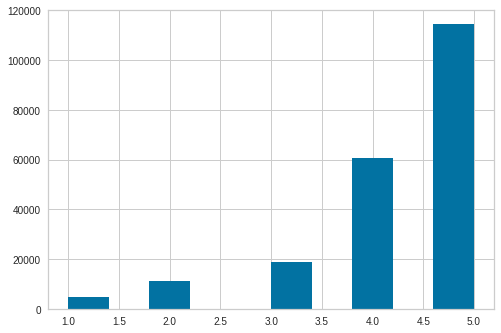

In [14]:
shuffled_df.rounded_rating.hist()

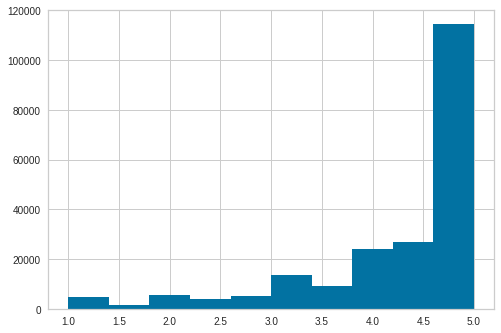

In [15]:
shuffled_df.Rating.hist()
plt.savefig('ratings_dist.png', format = 'png')

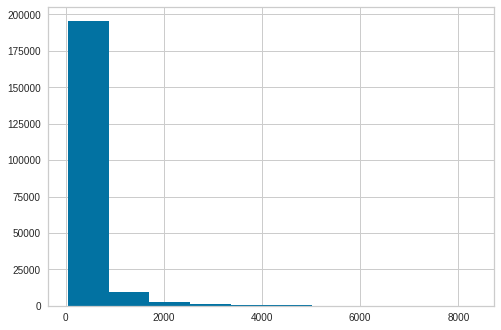

In [16]:
shuffled_df.review_word_count.hist()
plt.savefig('word_counts_dist.png', format='png')

In [17]:
shuffled_df.review_word_count.describe()

count    209500.000000
mean        533.062635
std         428.973192
min          50.000000
25%         299.000000
50%         482.000000
75%         670.000000
max        8319.000000
Name: review_word_count, dtype: float64

## Setup functions

In [18]:
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]
    # # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens

## Analysis settings

In [19]:
n_dim = 100
n_grams = 1
random_seed = 88
cores = multiprocessing.cpu_count()
STEMMING = True

## Sample documents

In [20]:
shuffled_df = shuffled_df.iloc[:1800]

# Vectorize Data

## Prepare data

In [21]:
# train_docs = list()
# gensim_train = list()
# for i in range(len(train_df)):
#     temp_text = train_df['Review'].iloc[i]
#     cleaned_doc = clean_doc(temp_text)
#     gensim_train.append(cleaned_doc)
#     #print(temp_text)
#     combined_text = ' '.join(clean_doc(temp_text))
#     train_docs.append(combined_text)

In [22]:
# test_docs = list()
# gensim_test = list()
# for i in range(len(test_df)):
#     temp_text = train_df['Review'].iloc[i]
#     cleaned_doc = clean_doc(temp_text)
#     gensim_test.append(cleaned_doc)
#     #print(temp_text)
#     combined_text = ' '.join(clean_doc(temp_text))
#     test_docs.append(combined_text)

In [23]:
docs = list()
gensim_docs = list()

for i in range(len(shuffled_df)):
    temp_text = shuffled_df['Review'].iloc[i]
    cleaned_doc = clean_doc(temp_text)
    gensim_docs.append(cleaned_doc)
    #print(temp_text)
    combined_text = ' '.join(clean_doc(temp_text))
    docs.append(combined_text)

## CountVectorizer

In [24]:
count_vec = CountVectorizer(ngram_range=(1, 1), max_features=100)
count_matrix = count_vec.fit_transform(docs)

In [25]:
count_matrix[0].toarray()

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [26]:
print(count_vec.get_feature_names()[:5])

['acceler', 'almost', 'alway', 'anoth', 'around']


## TF-IDF

In [27]:
tfidf_vec = TfidfVectorizer(ngram_range=(1, 1), max_features=100)
tfidf_matrix =tfidf_vec.fit_transform(docs)

In [28]:
tfidf_vec.get_feature_names()[:5]

['acceler', 'almost', 'alway', 'anoth', 'around']

In [29]:
tfidf_matrix.T[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [30]:
len(tfidf_vec.get_feature_names())

100

## Doc2Vec

In [31]:
train_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(gensim_docs)]
cores = multiprocessing.cpu_count()

print("\nWorking on Doc2Vec vectorization, dimension 100")
model_100 = Doc2Vec(train_corpus, vector_size = 100, window = 4, 
	min_count = 1, workers = cores, epochs = 20)

model_100.train(train_corpus, total_examples = model_100.corpus_count, 
	epochs = model_100.epochs)  # build vectorization model on training set

# vectorization for the training set
doc2vec_100_vectors = np.zeros((len(gensim_docs), 100)) # initialize numpy array
for i in range(0, len(gensim_docs)):
    doc2vec_100_vectors[i,] = model_100.infer_vector(gensim_docs[i]).transpose()
print('\nTraining doc2vec_100_vectors.shape:', doc2vec_100_vectors.shape)
# print('doc2vec_100_vectors[:2]:', doc2vec_100_vectors[:2])

# vectorization for the test set
# doc2vec_100_vectors_test = np.zeros((len(gensim_test), 100)) # initialize numpy array
# for i in range(0, len(gensim_test)):
#     doc2vec_100_vectors_test[i,] = model_100.infer_vector(gensim_test[i]).transpose()
# print('\nTest doc2vec_100_vectors_test.shape:', doc2vec_100_vectors_test.shape)


Working on Doc2Vec vectorization, dimension 100

Training doc2vec_100_vectors.shape: (1800, 100)


In [32]:
type(doc2vec_100_vectors)

numpy.ndarray

# Clustering Analysis

## CountVectorizer

In [33]:
k=5 # for the number of stars given to each review
km = KMeans(n_clusters=k, random_state =random_seed)
km.fit(count_matrix)
clusters = km.labels_.tolist()

terms = count_vec.get_feature_names()
Dictionary={'Cluster':clusters, 'Text': docs, 'Rating' : shuffled_df.rounded_rating.iloc[:1800]}
frame=pd.DataFrame(Dictionary, columns=['Rating', 'Cluster','Text'])
frame['record']=1
frame.head(n=10)

,Rating,Cluster,Text,record
1943,4.0,0,cadillac acura broke cadillac never broken alw...,1
3574,5.0,0,bought april absolut research drove differ veh...,1
3037,5.0,0,great reliabl handl element excel elev grip li...,1
5246,3.0,1,bought extra could lifetim bumper bumper warra...,1
8574,5.0,0,actual look suburban drove silverado hook love...,1
1267,3.0,0,bought drive infin total regret purchaseth thi...,1
5887,5.0,0,excel qualiti perform howev pleas economi lowe...,1
658,4.0,3,bought mile black paint superb leather seat le...,1
21798,4.0,3,problem noth mile still drive beat ride everi ...,1
10697,5.0,2,wonder toyota honda love expedit rise camper e...,1


In [34]:
frame[frame.Cluster == 3].Rating.mean()

3.681992337164751

In [35]:
frame[frame.Cluster == 0].Rating.mean()

4.398

In [36]:
frame[frame.Cluster == 1].Rating.mean()

4.216216216216216

In [37]:
frame[frame.Cluster == 2].Rating.mean()

4.493975903614458

In [38]:
frame[frame.Cluster == 4].Rating.mean()

4.522673031026253

In [39]:
frame.groupby(['Cluster']).mean()

,Rating,record
Cluster,,
0,4.398000,1
1,4.216216,1
2,4.493976,1
3,3.681992,1
4,4.522673,1


In [40]:
frame.groupby(['Cluster']).mean().to_excel('countvec_cluster_means.xlsx')

In [41]:
print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]

#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

# dictionary to store terms and titles
cluster_terms={}
cluster_title={}

for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms

Top terms per cluster:
Cluster 0:
 great
 vehicl
 drive
 look
 bought
 problem
 comfort
 would
 mile
 handl
Cluster 1:
 drive
 mile
 engin
 problem
 great
 would
 still
 first
 vehicl
 look
Cluster 2:
 truck
 drive
 great
 power
 problem
 mileag
 look
 better
 engin
 mile
Cluster 3:
 mile
 replac
 problem
 vehicl
 brake
 drive
 still
 bought
 year
 tire
Cluster 4:
 drive
 great
 comfort
 look
 mile
 vehicl
 handl
 mileag
 realli
 better


In [42]:
pivot=pd.pivot_table(frame, values='record', index='Rating',
                     columns='Cluster', aggfunc=np.sum, fill_value=0)

pivot.head(n=25)

Cluster,0,1,2,3,4
Rating,,,,,
1.0,15,0,1,12,7
2.0,33,3,2,34,4
3.0,79,6,5,56,20
4.0,285,8,22,82,120
5.0,588,20,53,77,268


In [43]:
pivot.to_excel('countvec_pivot.xlsx')

## TF-IDF

In [44]:
###############################################################################
### K Means Clustering - TFIDF
###############################################################################
#### Note: Here we carry out a clustering of the documents
k=5
km = KMeans(n_clusters=k, random_state =random_seed)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

terms = tfidf_vec.get_feature_names()
Dictionary={'Cluster':clusters, 'Text': docs, 'Rating' : shuffled_df.rounded_rating.iloc[:1800]}
frame=pd.DataFrame(Dictionary, columns=['Rating', 'Cluster','Text'])
frame['record']=1
frame.head()

,Rating,Cluster,Text,record
1943,4.0,0,cadillac acura broke cadillac never broken alw...,1
3574,5.0,2,bought april absolut research drove differ veh...,1
3037,5.0,2,great reliabl handl element excel elev grip li...,1
5246,3.0,1,bought extra could lifetim bumper bumper warra...,1
8574,5.0,2,actual look suburban drove silverado hook love...,1


In [45]:
print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]

#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

# dictionary to store terms and titles
cluster_terms={}
cluster_title={}

for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms

Top terms per cluster:
Cluster 0:
 truck
 great
 power
 drive
 mileag
 better
 mile
 look
 realli
 problem
Cluster 1:
 mile
 problem
 replac
 bought
 still
 brake
 repair
 dealer
 year
 issu
Cluster 2:
 great
 look
 power
 seat
 would
 comfort
 handl
 better
 perform
 purchas
Cluster 3:
 drive
 great
 comfort
 handl
 mileag
 look
 realli
 highway
 mile
 better
Cluster 4:
 vehicl
 drive
 look
 own
 would
 reliabl
 great
 comfort
 mile
 purchas


In [46]:
pivot=pd.pivot_table(frame, values='record', index='Rating',
                     columns='Cluster', aggfunc=np.sum, fill_value=0)

pivot.to_excel('tfidf_pivot.xlsx')
pivot

Cluster,0,1,2,3,4
Rating,,,,,
1.0,2,20,5,2,6
2.0,2,51,11,3,9
3.0,7,97,36,9,17
4.0,32,159,183,89,54
5.0,90,148,411,234,123


In [47]:
frame[frame.Cluster == 0].Rating.mean()

4.548872180451128

In [48]:
frame[frame.Cluster == 1].Rating.mean()

3.7663157894736843

In [49]:
frame[frame.Cluster == 2].Rating.mean()

4.523219814241486

In [50]:
frame[frame.Cluster == 3].Rating.mean()

4.632047477744807

In [51]:
frame[frame.Cluster == 4].Rating.mean()

4.3349282296650715

In [52]:
frame.groupby(['Cluster']).mean()

,Rating,record
Cluster,,
0,4.548872,1
1,3.766316,1
2,4.523220,1
3,4.632047,1
4,4.334928,1


In [53]:
frame.groupby(['Cluster']).mean().to_excel('tfidf_cluster_means.xlsx')

## Doc2Vec

In [54]:
k=5
km = KMeans(n_clusters=k, random_state =random_seed)
km.fit(doc2vec_100_vectors)
clusters = km.labels_.tolist()

#terms = tfidf_vec.get_feature_names()
Dictionary={'Cluster':clusters, 'Text': docs, 'Rating' : shuffled_df.rounded_rating.iloc[:1800]}
frame=pd.DataFrame(Dictionary, columns=['Rating', 'Cluster','Text'])
frame['record']=1
frame.head()

,Rating,Cluster,Text,record
1943,4.0,4,cadillac acura broke cadillac never broken alw...,1
3574,5.0,3,bought april absolut research drove differ veh...,1
3037,5.0,4,great reliabl handl element excel elev grip li...,1
5246,3.0,1,bought extra could lifetim bumper bumper warra...,1
8574,5.0,4,actual look suburban drove silverado hook love...,1


In [55]:
print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]

#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

# dictionary to store terms and titles
cluster_terms={}
cluster_title={}

for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms

    # print("Cluster %d titles:" % i, end='')
    # temp=frame[frame['Cluster']==i]
    # for title in temp['Car']:
    #     #print(' %s,' % title, end='')
    #     temp_titles.append(title)
    # cluster_title[i]=temp_titles

Top terms per cluster:
Cluster 0:
 problem
 dealership
 thing
 start
 small
 driven
 driver
 excel
 valu
 light
Cluster 1:
 start
 thing
 engin
 small
 driver
 driven
 dealership
 system
 front
 make
Cluster 2:
 dealership
 engin
 start
 alway
 almost
 enough
 highway
 driver
 make
 expect
Cluster 3:
 start
 thing
 valu
 driver
 problem
 light
 driven
 expect
 small
 dealership
Cluster 4:
 thing
 start
 driven
 small
 valu
 driver
 light
 problem
 dealership
 excel


In [56]:
pivot=pd.pivot_table(frame, values='record', index='Rating',
                     columns='Cluster', aggfunc=np.sum, fill_value=0)

pivot.to_excel('docvec_pivot.xlsx')
pivot

Cluster,0,1,2,3,4
Rating,,,,,
1.0,3,19,0,3,10
2.0,3,47,0,5,21
3.0,15,69,2,10,70
4.0,118,108,3,66,222
5.0,263,47,1,174,521


In [57]:
frame[frame.Cluster == 0].Rating.mean()

4.579601990049751

In [58]:
frame[frame.Cluster == 1].Rating.mean()

3.4034482758620688

In [59]:
frame[frame.Cluster == 2].Rating.mean()


3.8333333333333335

In [60]:
frame[frame.Cluster == 3].Rating.mean()

4.562015503875969

In [61]:
frame[frame.Cluster == 4].Rating.mean()

4.449052132701421

In [62]:
frame.groupby(['Cluster']).mean()

,Rating,record
Cluster,,
0,4.579602,1
1,3.403448,1
2,3.833333,1
3,4.562016,1
4,4.449052,1


In [63]:
frame.groupby(['Cluster']).mean().to_excel('docvec_cluster_means.xlsx')

# T-SNE Analysis

## CountVectorizer

In [64]:
#### Note: TSNE algorithm used for multidimensional scaling
mds = TSNE(n_components=2, metric="euclidean", random_state=random_seed)

# Note: The objective here is to obtain a picture of the documents in two dimensions
pos = mds.fit_transform(count_matrix.toarray())  # shape (n_components, n_samples)

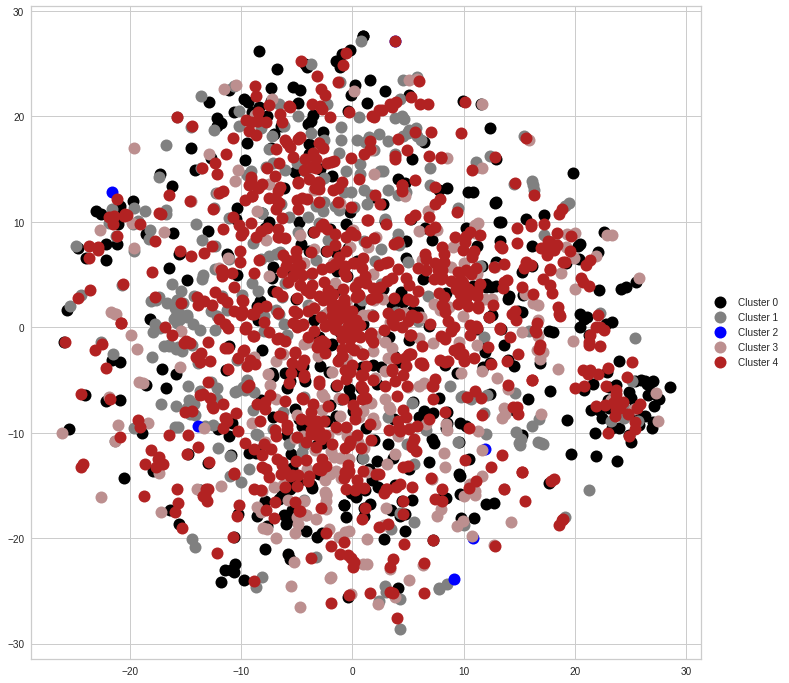

In [65]:
xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick'}

#set up cluster names using a dict.  
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 
                  4: 'Cluster 4'}

#set up cluster names using a dict.  
#cluster_dict = cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_labels[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #show legend with only 1 point
plt.savefig('countvec_tsne_docs.png', format = 'png')


## TF-IDF

In [66]:
#### Note: TSNE algorithm used for multidimensional scaling
mds = TSNE(n_components=2, metric="euclidean", random_state=random_seed)

# Note: The objective here is to obtain a picture of the documents in two dimensions
pos = mds.fit_transform(tfidf_matrix.toarray())  # shape (n_components, n_samples)

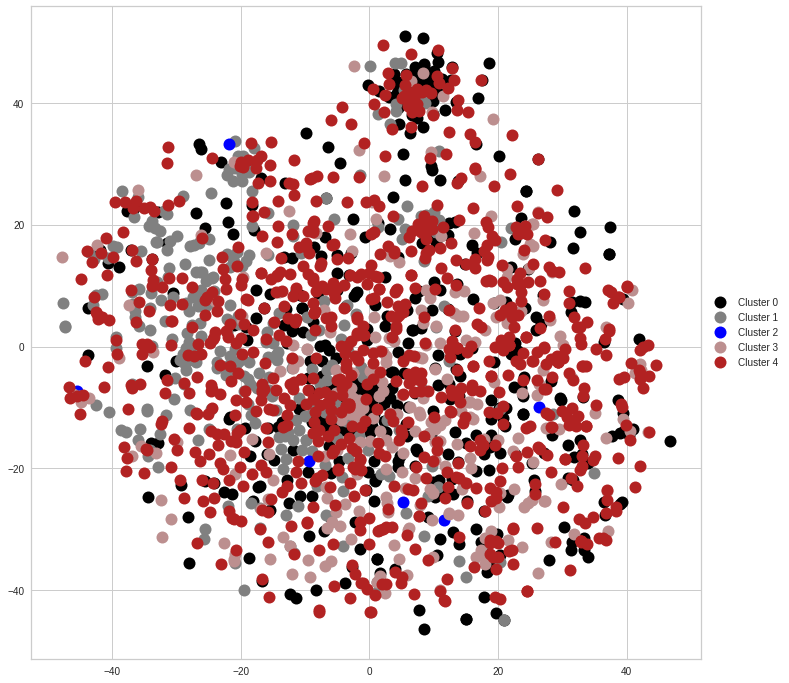

In [67]:
xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick'}

#set up cluster names using a dict.  
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 
                  4: 'Cluster 4'}

#set up cluster names using a dict.  
#cluster_dict = cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_labels[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #show legend with only 1 point
plt.savefig('tfidf_tsne_docs.png', format = 'png')

## Doc2Vec

In [68]:
#### Note: TSNE algorithm used for multidimensional scaling
mds = TSNE(n_components=2, metric="euclidean", random_state=random_seed)

# Note: The objective here is to obtain a picture of the documents in two dimensions
pos = mds.fit_transform(doc2vec_100_vectors)  # shape (n_components, n_samples)

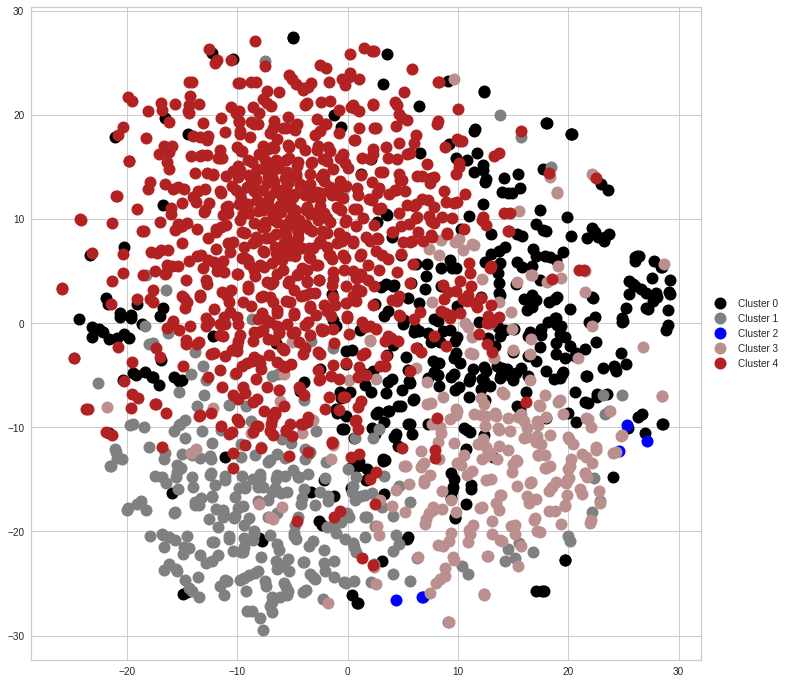

In [69]:
xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick'}

#set up cluster names using a dict.  
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 
                  4: 'Cluster 4'}

#set up cluster names using a dict.  
#cluster_dict = cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_labels[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #show legend with only 1 point

plt.savefig('docvec_tsne_docs.png', format = 'png')

In [70]:
for name,group in groups:
    print(name)
    print(group)

0
              x          y  label  title
9     25.887905   3.778670      0      9
17    15.377734   8.600786      0     17
24    15.292372   3.775768      0     24
30     3.073661 -22.855167      0     30
32    12.162220  -5.355712      0     32
...         ...        ...    ...    ...
1775  12.676327  -1.379308      0   1775
1778   8.271126  -6.029550      0   1778
1782  22.594603  -6.848573      0   1782
1786   9.528106 -15.776441      0   1786
1790  10.202386  -3.802971      0   1790

[402 rows x 4 columns]
1
              x          y  label  title
3     -7.716604 -29.474588      1      3
14   -13.876082  -2.739186      1     14
26    -8.424991 -24.018351      1     26
27    19.950792 -20.477461      1     27
33    -6.220368 -21.804670      1     33
...         ...        ...    ...    ...
1760  -6.411709 -14.597498      1   1760
1780   0.578159 -24.747349      1   1780
1784  -6.546992 -22.808519      1   1784
1789 -11.279647 -17.979156      1   1789
1797 -11.167364 -14.676120   

In [71]:
len(clusters)

1800

# t-SNE on words

## CountVectorizer

In [72]:
#### Note: TSNE algorithm used for multidimensional scaling
mds = TSNE(n_components=2, metric="euclidean", random_state=random_seed)

# Note: The objective here is to obtain a picture of the documents in two dimensions
pos = mds.fit_transform(count_matrix.T.toarray())  # shape (n_components, n_samples)

In [73]:
# k=5
# km = KMeans(n_clusters=k, random_state =random_seed)
# km.fit(count_matrix.T)
# clusters = km.labels_.tolist()

In [74]:
xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick'}

#set up cluster names using a dict.  
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 
                  4: 'Cluster 4'}

labels = np.array(count_vec.get_feature_names())

#set up cluster names using a dict.  
#cluster_dict = cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=labels)) 

#group by cluster
groups = df.groupby('label')

df.groupby('label')

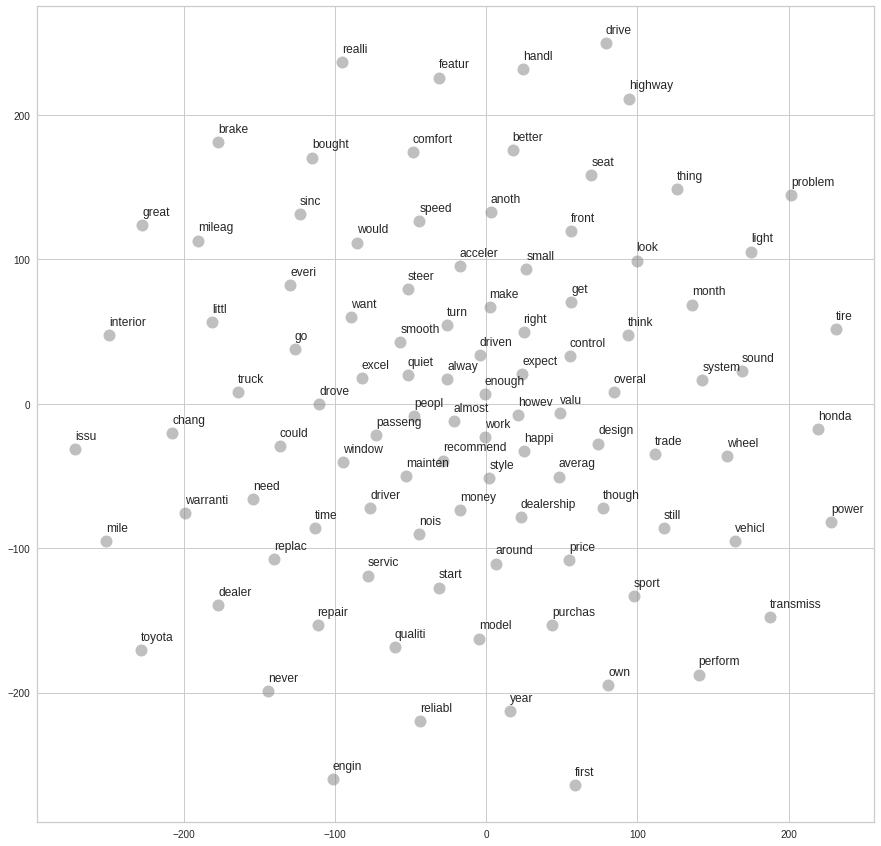

In [75]:
fig, ax = plt.subplots(figsize=(15, 15)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            #label=cluster_labels[name], color=cluster_colors[name], 
            mec='none',
            color = 'grey', alpha = 0.5)
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

    ax.annotate(name, (group.x, group.y),
                textcoords="offset points",
                xytext=(0,10))

plt.savefig('countvec_mds_terms.png', format = 'png')

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #show legend with only 1 point

## TF-IDF

In [76]:
#### Note: TSNE algorithm used for multidimensional scaling
mds = TSNE(n_components=2, metric="euclidean", random_state=random_seed)

# Note: The objective here is to obtain a picture of the documents in two dimensions
pos = mds.fit_transform(tfidf_matrix.T.toarray())  # shape (n_components, n_samples)

In [77]:
xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick'}

#set up cluster names using a dict.  
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 
                  4: 'Cluster 4'}

labels = np.array(tfidf_vec.get_feature_names())

#set up cluster names using a dict.  
#cluster_dict = cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=labels)) 

#group by cluster
groups = df.groupby('label')

df.groupby('label')

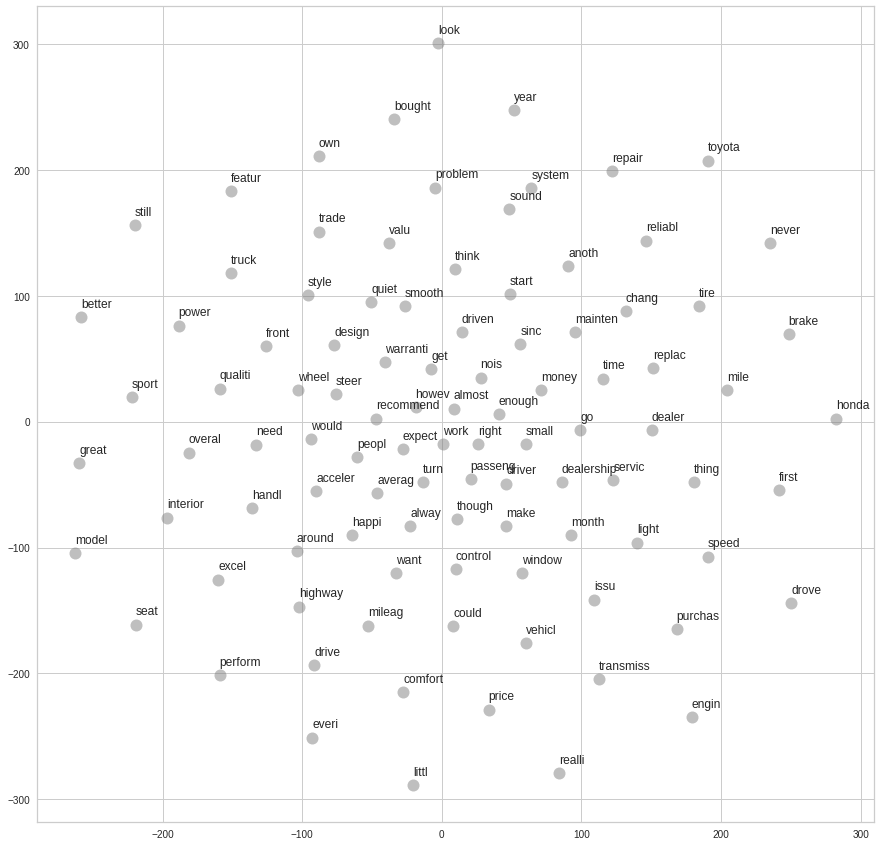

In [78]:
fig, ax = plt.subplots(figsize=(15, 15)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            #label=cluster_labels[name], color=cluster_colors[name], 
            mec='none',
            color='grey',
            alpha = 0.5)
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

    ax.annotate(name, (group.x, group.y),
                textcoords="offset points",
                xytext=(0,10))
plt.savefig('tfidf_mds_terms.png', format = 'png')

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #show legend with only 1 point

## CountVectorizer

# Hierarchical Cluster Analysis

In [79]:
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist

dist = pdist(count_matrix.T.toarray())
linked = linkage(dist, method='ward')
fcluster = fcluster(linked, 0, criterion = 'distance')

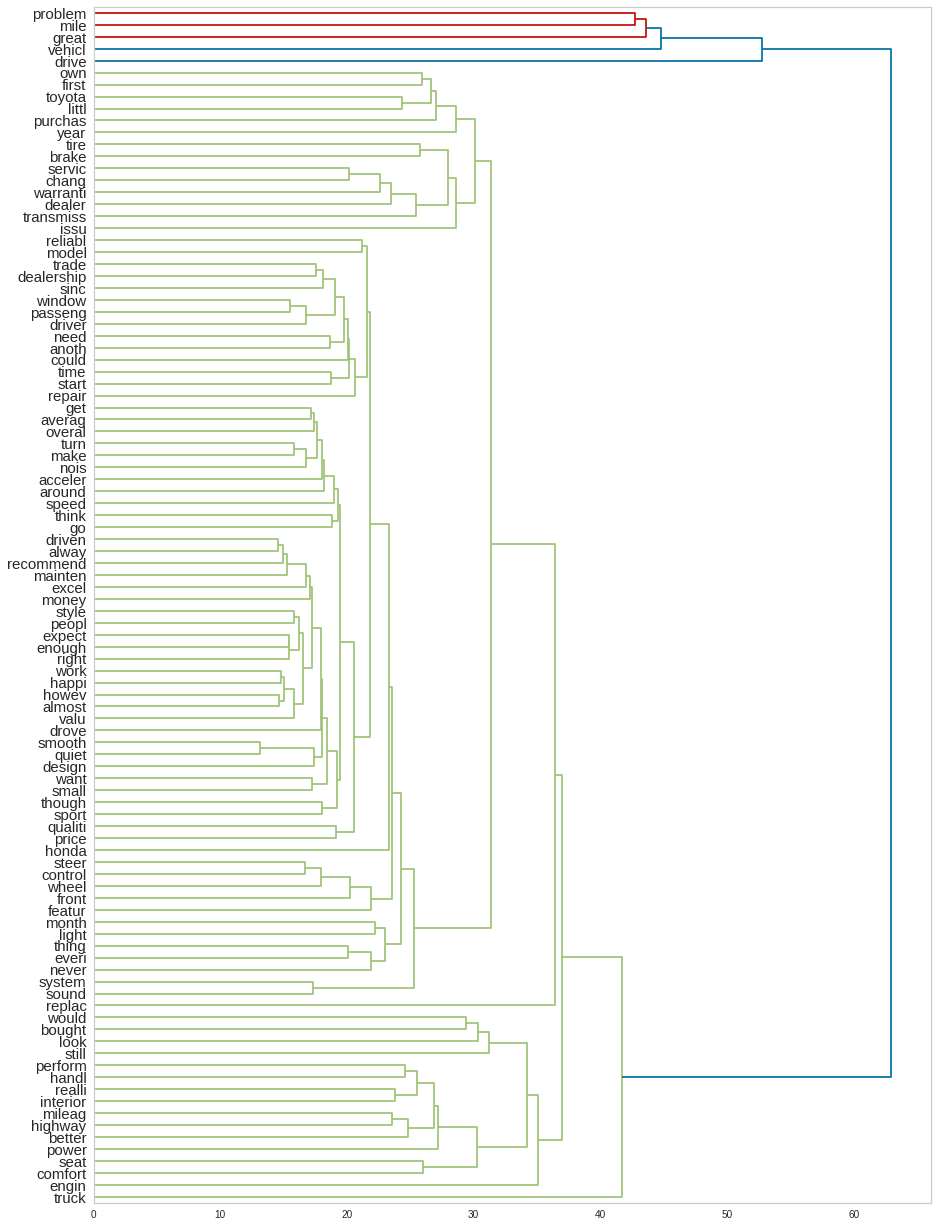

In [80]:
linked = linkage(count_matrix.T.toarray(), method='ward')

plt.subplots(figsize=(15, 22)) # set size
dendrogram(linked, 
            labels = count_vec.get_feature_names(),
            orientation='right')

plt.tick_params(axis='y', labelsize=15)
plt.grid(False)
plt.savefig('countvec_dendrogram.png', format = 'png')
plt.show()

## TF-IDF

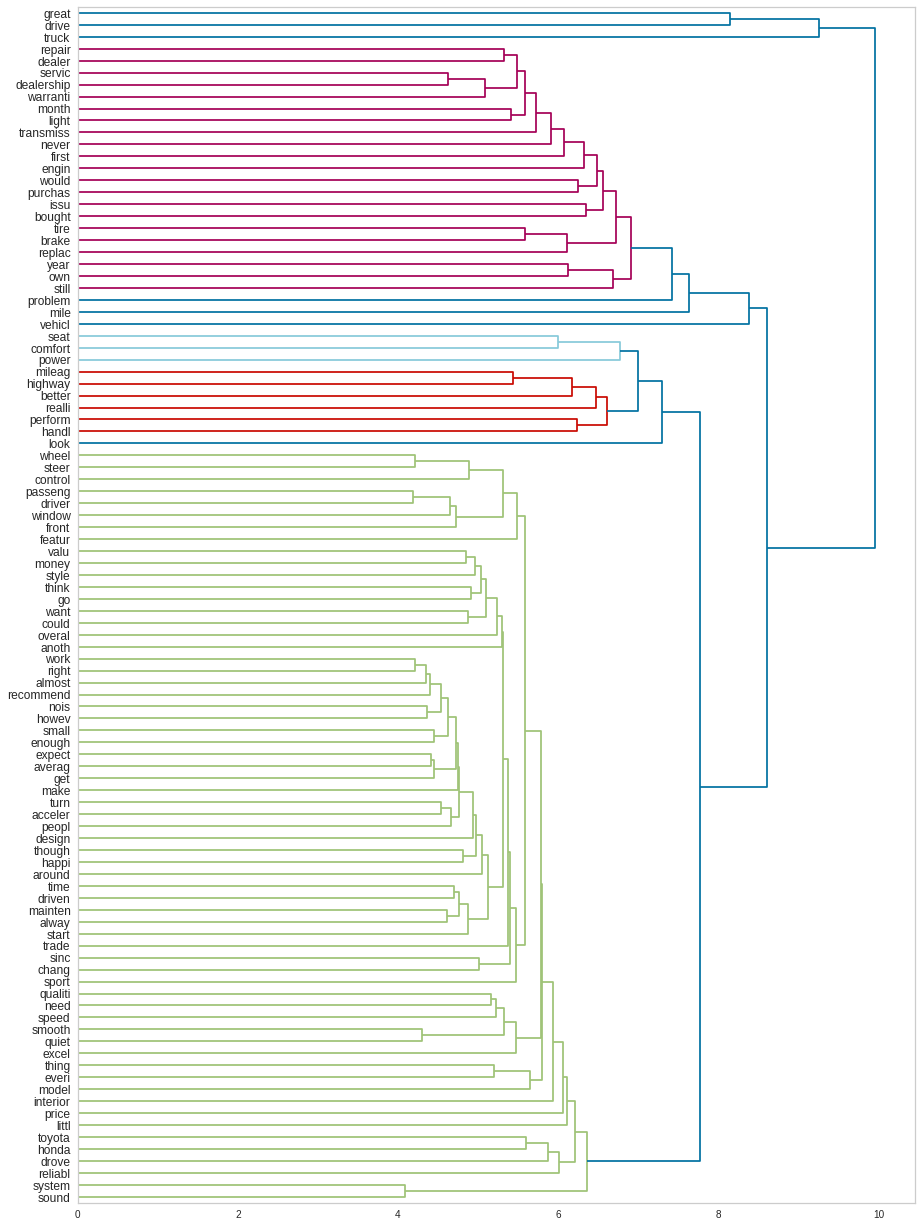

In [81]:
linked = linkage(tfidf_matrix.T.toarray(), method='ward')

plt.subplots(figsize=(15, 22)) # set size
dendrogram(linked,
            labels = tfidf_vec.get_feature_names(),
            orientation = 'right')
# plt.savefig('C:\\Users\\bxiao\Documents\\school_files\\453_nlp\\assignments\\453_assignment03\\tfidf_dendrogram01.png', 
#                 format = 'png', dpi = 1600)
plt.tick_params(axis='y', labelsize=12)
plt.grid(False)
plt.savefig('tfidf_dendrogram.png', format = 'png')
plt.show()
